In [1]:
import numpy as np # linear algebra
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel,BertTokenizer,get_linear_schedule_with_warmup
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import re
import contractions
import string
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("omw-1.4")


df = pd.read_csv("/content/sentiment_data.csv",delimiter=',')
df.head()

cuda


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


In [4]:
df.drop("Unnamed: 0",inplace=True,axis=1)


In [5]:
print("Null Values\n")
print(df.isnull().sum())
print('Duplicates\n')
print(df.duplicated().sum())
print("dtypes\n")
print(df.dtypes)

Null Values

Comment      217
Sentiment      0
dtype: int64
Duplicates

26809
dtypes

Comment      object
Sentiment     int64
dtype: object


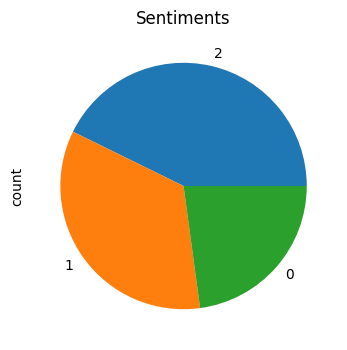

np.int64(26809)

In [6]:
plt.figure(figsize=(10,4))
df['Sentiment'].value_counts().plot(kind='pie',rot="%1.1f%%")
plt.title("Sentiments")
plt.show()


df['Comment'] = df['Comment'].fillna("")
df.duplicated().sum()

In [7]:
df.drop_duplicates(inplace=True)

df['Comment'].head(10)

,Comment
0,lets forget apple pay required brand new iphon...
1,nz retailers don’t even contactless credit car...
2,forever acknowledge channel help lessons ideas...
3,whenever go place doesn’t take apple pay doesn...
4,apple pay convenient secure easy use used kore...
5,we’ve hounding bank adopt apple pay understand...
6,got apple pay south africa it’s widely accepted
7,need apple pay physical credit card
8,united states abundance retailers accept apple...
9,cambodia universal qr code system scan send mo...


In [8]:
# Cleaning Text Data
import nltk
nltk.download('punkt_tab') # Download the missing resource

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>','',text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z0-9\s]','',text)
    text = contractions.fix(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    STOPWORDS = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in STOPWORDS]
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(token) for token in tokens]
    text = " ".join(tokens)
    return text

df['clean_text'] = df['Comment'].apply(clean_text)
df['clean_text'].head(10)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,clean_text
0,let u forget apple pay required brand new ipho...
1,nz retailer even contactless credit card machi...
2,forever acknowledge channel help lesson idea e...
3,whenever go place take apple pay happen often ...
4,apple pay convenient secure easy use used kore...
5,hounding bank adopt apple pay understand want ...
6,got apple pay south africa widely accepted
7,need apple pay physical credit card
8,united state abundance retailer accept apple p...
9,cambodia universal qr code system scan send mo...


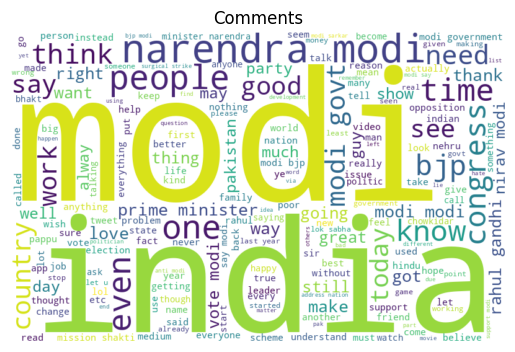

In [9]:
sample = " ".join(i for i in df['clean_text'].astype(str))


wc = WordCloud(height=500,width=800,background_color="white").generate(sample)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("Comments")
plt.show()

In [10]:
top_100_most_common_words = nltk.FreqDist(TextBlob(sample).words).most_common(100)
print('Top 100 Most Common Words\n')
print(top_100_most_common_words)

Top 100 Most Common Words

[('modi', 149422), ('india', 29655), ('like', 18230), ('people', 17591), ('bjp', 14134), ('one', 13665), ('time', 13021), ('congress', 12429), ('election', 11326), ('narendra', 11034), ('year', 10849), ('vote', 10543), ('get', 10370), ('say', 10263), ('want', 9848), ('know', 9815), ('govt', 9628), ('good', 9226), ('indian', 9191), ('would', 8840), ('country', 8618), ('day', 8522), ('even', 8411), ('also', 8112), ('make', 8095), ('work', 7689), ('modis', 7554), ('see', 7413), ('need', 7234), ('nation', 7064), ('rahul', 6959), ('give', 6879), ('great', 6699), ('think', 6633), ('app', 6466), ('party', 6459), ('love', 6360), ('back', 6203), ('come', 6164), ('government', 6104), ('going', 6081), ('take', 6048), ('much', 6017), ('power', 5828), ('thing', 5801), ('gandhi', 5768), ('minister', 5688), ('new', 5634), ('done', 5526), ('said', 5512), ('today', 5501), ('way', 5442), ('money', 5433), ('really', 5412), ('every', 5398), ('leader', 5350), ('never', 5306), ('w

In [11]:
nlp = spacy.load("en_core_web_sm")

doc = nlp(sample[:5000])


##entity-linking


for ent in doc.ents:
    print("entities in document\n")
    print(ent.text,"|",spacy.explain(ent.label_))

entities in document

korean | Nationalities or religious or political groups
entities in document

japanese | Nationalities or religious or political groups
entities in document

south africa | Countries, cities, states
entities in document

abandon po | People, including fictional
entities in document

one | Numerals that do not fall under another type
entities in document

dan | People, including fictional
entities in document

one | Numerals that do not fall under another type
entities in document

dan | People, including fictional
entities in document

brian electrician dan | People, including fictional
entities in document

dan | People, including fictional
entities in document

dan | People, including fictional
entities in document

one | Numerals that do not fall under another type
entities in document

million | Numerals that do not fall under another type
entities in document

year ago | Absolute or relative dates or periods
entities in document

one | Numerals that do not fa

In [12]:
tfid = TfidfVectorizer()

X = df['clean_text']
y = df['Sentiment']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=1)

X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

In [13]:
models = {
"bernoulinaivebayes":BernoulliNB(),
"multinomialnaivebayes":MultinomialNB(),
"logisticregression":LogisticRegression(),
"passiveagressiveclassifier":PassiveAggressiveClassifier()
}



for model_name,model in models.items():
    model.fit(X_train_tfid,y_train)
    pred = model.predict(X_test_tfid)
    clf_rpt = classification_report(y_test,pred)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test,pred,average="micro")
    print(f'{model.__class__.__name__}; --Accuracy-- {acc*100:.2f}%; --Classification Report-- {clf_rpt}')
    print(f'{model.__class__.__name__}; --F1 Score-- {f1*100:.2f}%')

BernoulliNB; --Accuracy-- 67.11%; --Classification Report--               precision    recall  f1-score   support

           0       0.70      0.39      0.50      9727
           1       0.62      0.77      0.69     14458
           2       0.71      0.74      0.73     18683

    accuracy                           0.67     42868
   macro avg       0.68      0.63      0.64     42868
weighted avg       0.68      0.67      0.66     42868

BernoulliNB; --F1 Score-- 67.11%
MultinomialNB; --Accuracy-- 54.53%; --Classification Report--               precision    recall  f1-score   support

           0       0.88      0.15      0.25      9727
           1       0.75      0.27      0.40     14458
           2       0.50      0.97      0.66     18683

    accuracy                           0.55     42868
   macro avg       0.71      0.46      0.44     42868
weighted avg       0.67      0.55      0.48     42868

MultinomialNB; --F1 Score-- 54.53%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression; --Accuracy-- 79.82%; --Classification Report--               precision    recall  f1-score   support

           0       0.79      0.67      0.72      9727
           1       0.76      0.84      0.80     14458
           2       0.84      0.84      0.84     18683

    accuracy                           0.80     42868
   macro avg       0.80      0.78      0.79     42868
weighted avg       0.80      0.80      0.80     42868

LogisticRegression; --F1 Score-- 79.82%
PassiveAggressiveClassifier; --Accuracy-- 74.93%; --Classification Report--               precision    recall  f1-score   support

           0       0.70      0.65      0.68      9727
           1       0.72      0.77      0.74     14458
           2       0.80      0.79      0.79     18683

    accuracy                           0.75     42868
   macro avg       0.74      0.74      0.74     42868
weighted avg       0.75      0.75      0.75     42868

PassiveAggressiveClassifier; --F1 Score-- 74.93%


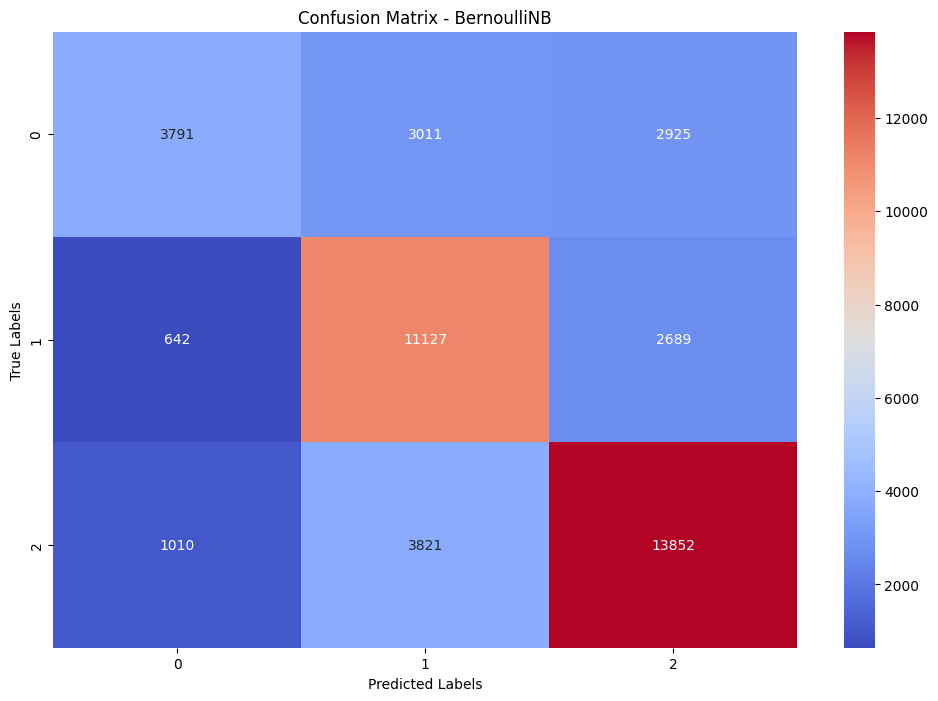

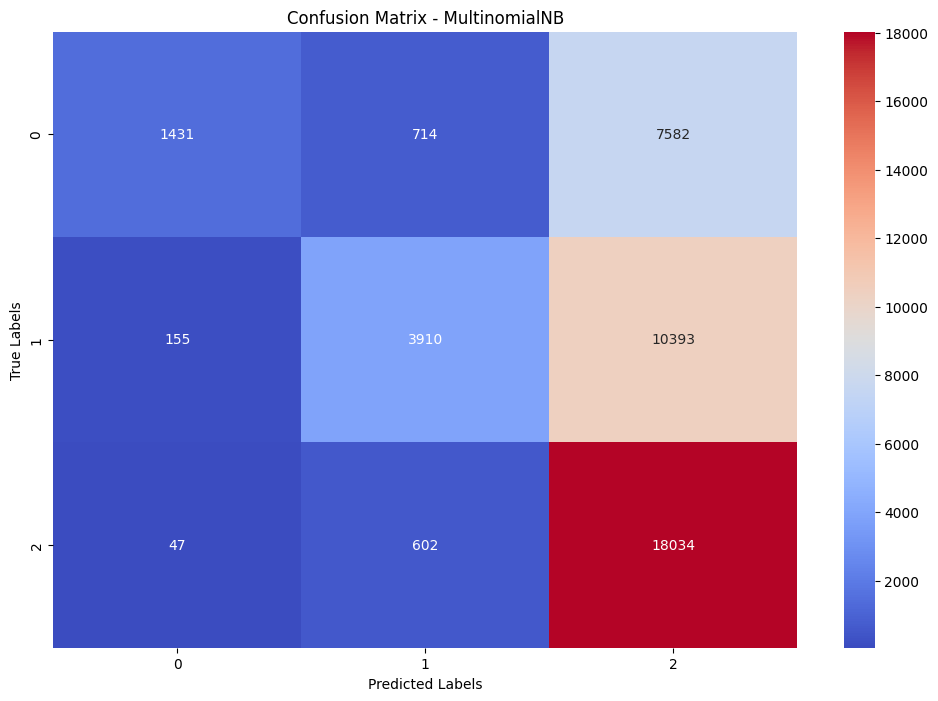

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


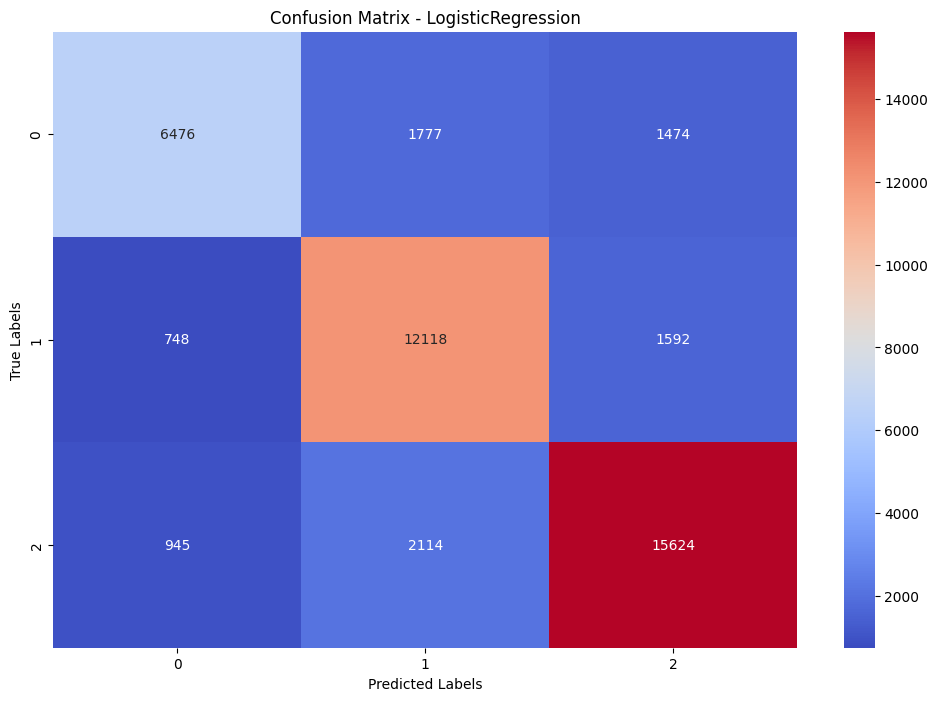

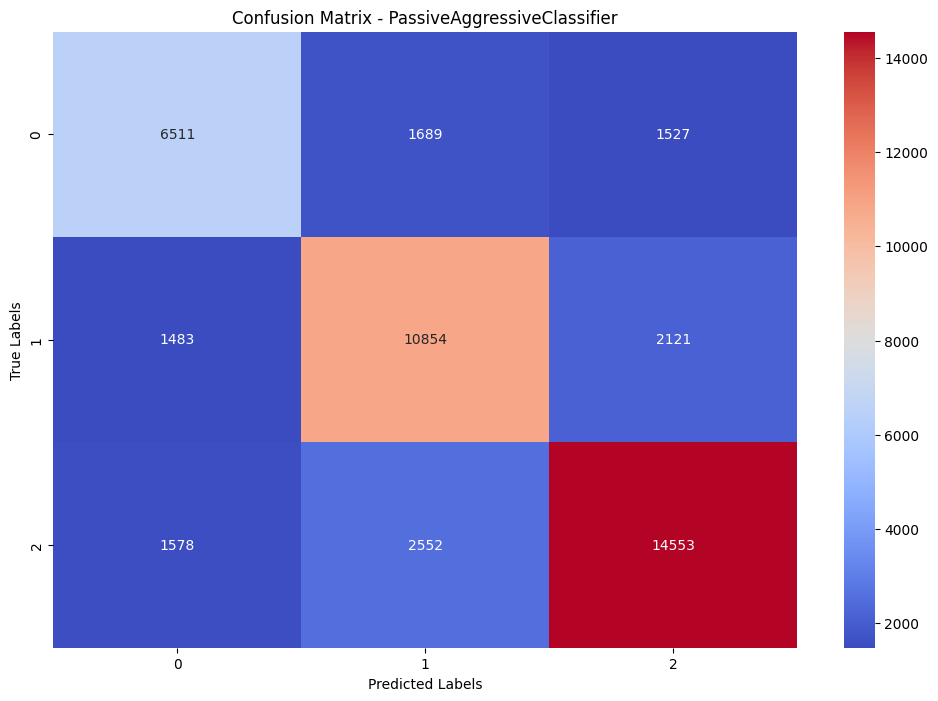

In [14]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_test, y_pred, model):
    conmap = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,8))
    sns.heatmap(conmap, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()


for model_name, model in models.items():
    model = model.fit(X_train_tfid, y_train)
    y_pred = model.predict(X_test_tfid)
    plot_confusion_matrix(y_test, y_pred, model)

In [15]:
# Fine-Tuning Bert

df_bert = df[['Sentiment','Comment']]
df_bert.head(10)


,Sentiment,Comment
0,1,lets forget apple pay required brand new iphon...
1,0,nz retailers don’t even contactless credit car...
2,2,forever acknowledge channel help lessons ideas...
3,0,whenever go place doesn’t take apple pay doesn...
4,2,apple pay convenient secure easy use used kore...
5,1,we’ve hounding bank adopt apple pay understand...
6,2,got apple pay south africa it’s widely accepted
7,1,need apple pay physical credit card
8,2,united states abundance retailers accept apple...
9,1,cambodia universal qr code system scan send mo...


In [16]:
print('Null Values\n')
print(df_bert.isnull().sum())
print('Duplicated Values\n')
print(df_bert.duplicated().sum())

Null Values

Sentiment    0
Comment      0
dtype: int64
Duplicated Values

0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


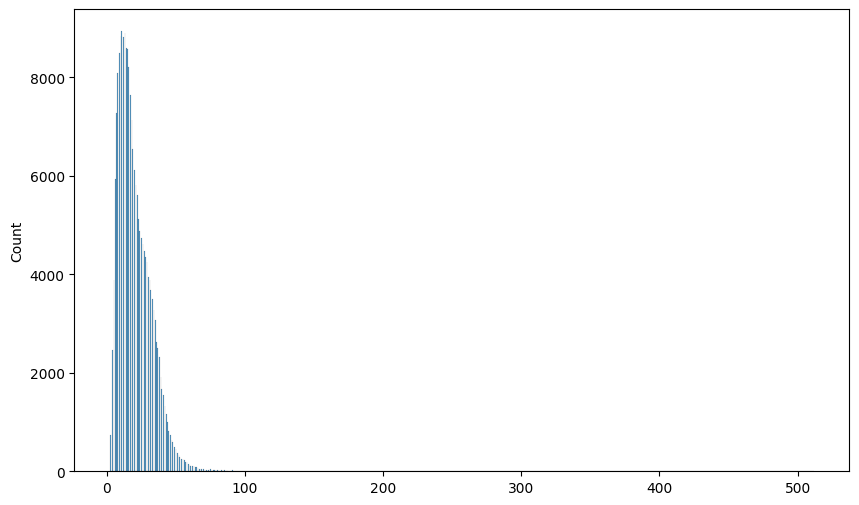

In [17]:
MODEL_NAME = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

sample_tokens = []
for txt in df_bert['Comment']:
    tokens = tokenizer.encode(txt,max_length=512)
    sample_tokens.append(len(tokens))



plt.figure(figsize=(10,6))
sns.histplot(sample_tokens)
plt.show()

In [18]:
MAX_LEN = 80


class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self,Comment,max_len,tokenizer,targets):
        self.Comment = Comment
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.targets = targets

    def __len__(self):
        return len(self.Comment)

    def __getitem__(self,index):
        Comment = str(self.Comment[index])
        target = self.targets[index]

        encoder = self.tokenizer.encode_plus(
        Comment,
        max_length=self.max_len,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_token_type_ids=False,
        add_special_tokens=True,
        return_tensors="pt",
                )

        return {
        "Comment":Comment,
        "input_ids":encoder['input_ids'].flatten(),
        "attention_mask":encoder['attention_mask'].flatten(),
        "targets": torch.tensor(target,dtype=torch.long)
        }


df_train,df_test = train_test_split(df,test_size=.10,random_state=1)
df_val,df_test = train_test_split(df_test,test_size=.50,random_state=1)


BATCH_SIZE = 12
learning_rate = 2e-5
epochs = 4
def get_dataloader(df_bert,tokenizer,max_len,batch_size):
    ds = Custom_Dataset(
        Comment = df_bert['Comment'].to_numpy(),
        targets = df_bert['Sentiment'].to_numpy(),
        max_len=max_len,
        tokenizer=tokenizer
    )
    return torch.utils.data.DataLoader(
        ds,
        num_workers=4,
        batch_size=batch_size
    )

In [19]:
train_dataloader = get_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = get_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = get_dataloader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)


data = next(iter(train_dataloader))
data.keys()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


dict_keys(['Comment', 'input_ids', 'attention_mask', 'targets'])

In [20]:
class Bert_Classifier(nn.Module):
    def __init__(self):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(768,3)


    def forward(self,input_ids,attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooler_output = outputs.pooler_output
        output = self.drop(pooler_output)
        return self.out(output)



model = Bert_Classifier()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [21]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [22]:
df_train = df_train.sample(frac=0.2, random_state=42)
df_val = df_val.sample(frac=0.2, random_state=42)
df_test = df_test.sample(frac=0.2, random_state=42)

In [23]:
epochs = 2

In [24]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

def training_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    predictions = 0

    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        optimizer.zero_grad()

        with autocast():  # Mixed precision
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
            )
            loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)
        predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    return (predictions.double() / n_examples, np.mean(losses))


def eval_model(model, dataloader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    predictions = 0

    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return (predictions.double() / n_examples, np.mean(losses))

/tmp/ipython-input-3075433444.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [25]:
# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    train_acc, train_loss = training_epoch(
        model, train_dataloader, loss_fn, optimizer, device, scheduler, len(df_train)
    )

    val_acc, val_loss = eval_model(
        model, val_dataloader, loss_fn, device, len(df_val)
    )

    print(f'Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


# Final test accuracy
test_acc, _ = eval_model(model, test_dataloader, loss_fn, device, len(df_test))
print(f'Test Accuracy: {test_acc.item() * 100:.2f}%')

Epoch 1/2


/tmp/ipython-input-3075433444.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Train Acc: 416.98%, Val Acc: 431.50%
Train Loss: 0.4621, Val Loss: 0.4019
Epoch 2/2
Train Acc: 443.83%, Val Acc: 434.02%
Train Loss: 0.3444, Val Loss: 0.4075
Test Accuracy: 432.62%


In [27]:
def get_predictions(model, dataloader):
  model.eval()

  Comments = []
  pred = []

  real_values = []

  with torch.no_grad():
    for d in dataloader:

      Comment = d["Comment"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      Comments.extend(Comment)
      pred.extend(preds)
      real_values.extend(targets)

  pred = torch.stack(pred).cpu()
  real_values = torch.stack(real_values).cpu()
  return Comments, pred,real_values


y_Comments,y_pred,y_test = get_predictions(model, test_dataloader)

In [28]:
clf_rpt = classification_report(y_test, y_pred)
print(f"Classification Report: {clf_rpt}")

Classification Report:               precision    recall  f1-score   support

           0       0.84      0.81      0.82      2413
           1       0.84      0.87      0.86      3599
           2       0.90      0.89      0.89      4705

    accuracy                           0.87     10717
   macro avg       0.86      0.86      0.86     10717
weighted avg       0.87      0.87      0.87     10717

